In [3]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep as fallasleep
import os, sys

In [6]:
from source.colortools import color_box

# Import data from Kraken 
source: [https://www.kraken.com/]

In [7]:
import krakenex
from pykrakenapi import KrakenAPI

### Choice of coins
- Ethereum: smart contract that is powering lots of Dapps.
- BTC:      still has the crown of all crypto.
- XRP:      fastest transaction speed, that has the most potential being used within the financial institutions.
- ADA:      Cardano uses third-generation proof-of-state with a strong focus on sustainability, scalability, and transparency.
- DOT:      polkadot is a multichain network that aims to be the central network that connects to other network protocols.

In [8]:
api = krakenex.API()
k = KrakenAPI(api)
coins = ["ETH", "BTC", "XRP", "ADA", "DOT"]
coins = coins[2:]
gapmin= 1440
coins = [coin+"USD" for coin in coins]
df = {}
colormapper = {}
for _,coin in enumerate(coins):
    data, last = k.get_ohlc_data(coin, interval = gapmin, ascending = True)
    df[coin]=data.drop(['time', 'count'], axis=1)
    colormapper[coin] = color_box[_]
    fallasleep(1)


In [9]:
df_close = pd.DataFrame(columns=coins)
for coin in coins:
    df_close[coin] = df[coin]['close']

In [10]:
df_close.isna().sum()

XRPUSD      0
ADAUSD      0
DOTUSD    260
dtype: int64

In [11]:
df_close = df_close.dropna()
df_close.isna().sum()

XRPUSD    0
ADAUSD    0
DOTUSD    0
dtype: int64

In [12]:
df_close.head(3)

,XRPUSD,ADAUSD,DOTUSD
dtime,,,
2020-08-18,0.30292,0.137218,3.1099
2020-08-19,0.28992,0.129678,2.9175
2020-08-20,0.29246,0.134305,2.9090


In [13]:
df_close_diff = df_close.apply(np.log).diff().dropna()
df_close_diff.head(3)

,XRPUSD,ADAUSD,DOTUSD
dtime,,,
2020-08-19,-0.043864,-0.056516,-0.063863
2020-08-20,0.008723,0.035059,-0.002918
2020-08-21,-0.046364,-0.087043,0.056341


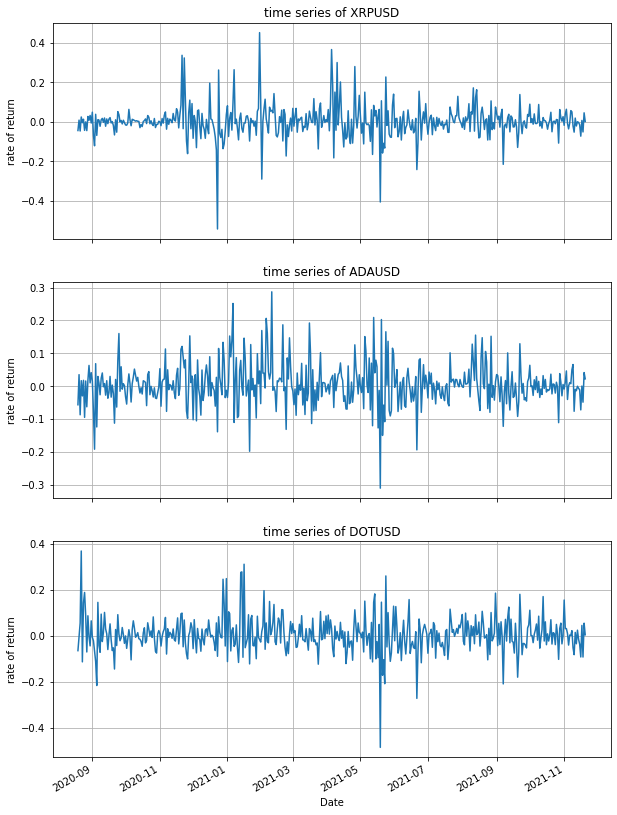

In [14]:
# fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(len(df_close_diff.columns),1,figsize=(10,15))
for _,col in enumerate(df_close_diff):
    ax[_].plot(df_close_diff.index, df_close_diff[col].values)
    ax[_].set_title(f"time series of {col}")
    ax[_].set_ylabel("rate of return")
    ax[_].set_xlabel("Date")
    ax[_].grid()
fig.autofmt_xdate()
plt.show()

### Mean-Variance Optimization (with cardinality constraint) - BUY/NOT BUY
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2} \lambda x^TQx - (1 - \lambda) r^Tx\\
        &\text{subject to}&& \mathbf{1}^Tx = k\\
        &&& x \in \{0,1\}\\
        &&& \lambda \in [0,1]\\
\end{aligned}
$$

In [15]:
Q = df_close_diff.cov().values
r = df_close_diff.mean().values

## Using Gurobi

In [16]:
from gurobipy import *

In [17]:
def obj_val(x):
    return 0.5 * lam * (x @ Q @ x) - (1 - lam) * (r @ x)

def print_bold(string, end=False):
    if end:
        print('\033[91m' + '\033[1m' + string + '\033[0m',end="")
    else:
        
        print('\033[91m' + '\033[1m' + string + '\033[0m')

In [18]:
m   = Model("MVO")
x   = {}
n   = len(Q)
lam = 0.5
k   = 2
x   = m.addMVar(shape=n,vtype=GRB.BINARY, name=coins)
obj = 0.5 * lam * (x @ Q @ x) - (1 - lam) * (r @ x)
m.addConstr(x.sum()==k)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

selected = []
gurobi   = []
for v in m.getVars():
    gurobi.append(int(v.x))
    if v.x == 1:
        selected.append(v.VarName)
print(f"Gurobi selected:         {selected}")
print(f"Gurobi optimal solution: {gurobi}")
print(f"Gurobi optimal value:    {obj_val(gurobi)}")

Restricted license - for non-production use only - expires 2022-01-13
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0x10d57811
Model has 6 quadratic objective terms
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 3e-03]
  QObjective range [2e-03, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0001495
Presolve time: 0.00s
Presolved: 4 rows, 6 columns, 12 nonzeros
Variable types: 0 continuous, 6 integer (6 binary)

Root relaxation: objective -1.596070e-03, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      -0.0015961  

## Using Qiskit

In [19]:
from qiskit                                   import Aer
from qiskit.algorithms                        import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers             import COBYLA
from qiskit.circuit.library                   import TwoLocal
from qiskit.utils                             import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms           import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit_optimization.converters           import QuadraticProgramToQubo
from qiskit.utils                             import algorithm_globals

### Mean-Variance Optimization (with cardinality constraint), Unconstrained - BUY/SELL
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2} \lambda x^TQx - (1 - \lambda) r^Tx +  P \cdot (\mathbf{1}^Tx - k) \cdot (\mathbf{1}^Tx - k)\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

In [20]:
portfolio = PortfolioOptimization(expected_returns=(1-lam)*r, covariances=0.5*Q,
                                  risk_factor=lam, budget=k)
qp = portfolio.to_quadratic_program()
num_qubits = n
seed = 6969

### VQE

In [21]:
def selection_to_picks(num_assets, selection):
    purchase = []
    for i in range(num_assets):
        if selection[i] == 1:
            purchase.append(coins[i])
    return purchase

def index_to_selection(i, n):
    s = "{0:b}".format(i).rjust(n)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(n))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.6f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    states, values, probs = [], [], []
    for i in i_sorted:
        x = index_to_selection(i, n)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        if (x == gurobi).all():
            print_bold('%10s\t%.6f\t\t%.6f' %(x, value, probability))
        else:
            print('%10s\t%.6f\t\t%.6f' %(x, value, probability))
        states.append(''.join(str(i) for i in x))
        values.append(value)
        probs.append(probability)
    return selection, states, values, probs

In [22]:
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=2500)
ry = TwoLocal(n, 'ry', 'cz', reps=3, entanglement='full')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

selection, state, values, probabilities = print_result(result)
print(f"VQE selected:          {selection_to_picks(n, selection)}")
print(f"VQE optimal solution:  {selection}")
print(f"VQE optimal value:     {obj_val(selection)}")

/home/ape/anaconda3/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


Optimal: selection [0. 1. 1.], value -0.001596

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
   [1 0 1]	0.000416		0.914856
   [1 1 0]	-0.000150		0.066941
   [0 1 1]	-0.001596		0.018203
   [0 1 0]	1.013906		0.000000
   [0 0 1]	1.014372		0.000000
   [1 0 0]	1.015956		0.000000
   [1 1 1]	1.017222		0.000000
   [0 0 0]	4.062785		0.000000
VQE selected:          ['ADAUSD', 'DOTUSD']
VQE optimal solution:  [0. 1. 1.]
VQE optimal value:     -0.0015960698992559036


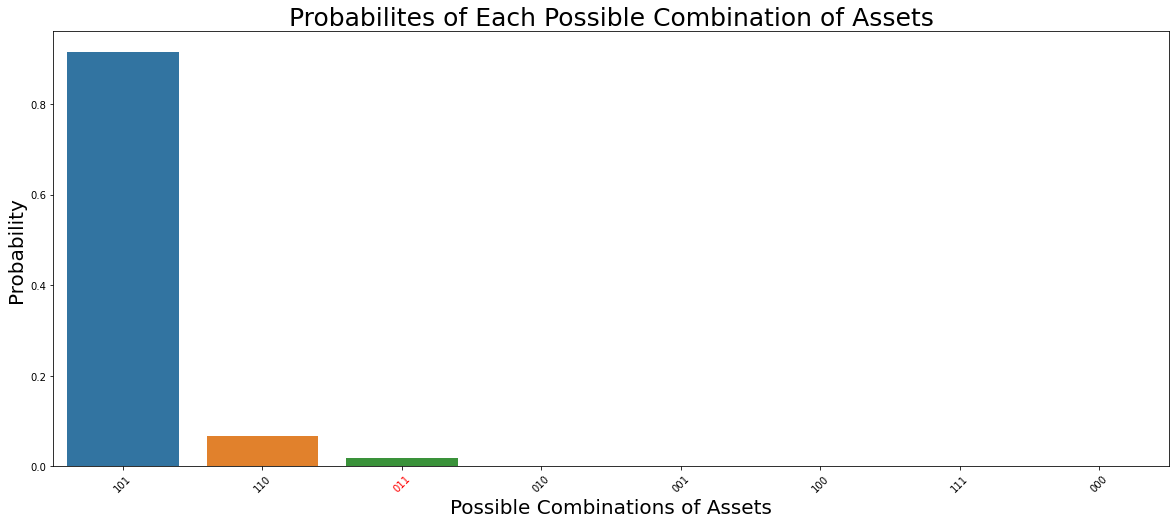

In [23]:
fig, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(x=state, y=probabilities)
for _,item in enumerate(optimized_value.get_xticklabels()):
    item.set_rotation(45)
    if item.get_text() == ''.join(str(s) for s in gurobi):
        ax.get_xticklabels()[_].set_color("red")
ax.set_title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
ax.set_xlabel('Possible Combinations of Assets',fontsize =20)
ax.set_ylabel('Probability',fontsize = 20)
plt.show()

### Circuit Design

### Mean-Variance Optimization (cardinality constraint) - Unconstrained - BUY/SELL
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2}\lambda x^TQx - (1 - \lambda)r^Tx +  P \cdot (\mathbf{1}^Tx - k) \cdot (\mathbf{1}^Tx - k)\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

Here, we set $P \approx \mathbb{E}[-\frac{k^2\lambda}{2n^2}\sum_{i=0}^n\sum_{i=0}^n q_{ij} + \frac{k(1-\lambda)}{n}\sum_{i=0}^nr_i]$
The corresponding QUBO formulation for our problem is as follows:
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & x^T \left[\frac{\lambda}{2}Q + P\mathbb{1} \mathbb{1}^T \right] x - \left[(1-\lambda)r + 2Pk\mathbb{1} \right]^T x + C\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

#### Corresponding Ising Model

define a new variable $s$ such that $x = \frac{1-s}{2}$, so $s \in \{-1, 1\}$

$$
\begin{aligned}
& \underset{s}{\text{minimize}} & & s^T \left[\frac{1}{4}\left(\frac{\lambda}{2}Q+P\mathbb{1}\mathbb{1}^T\right)\right]s
- \left[(1-\lambda)r + 2Pk\mathbb{1} \right]^Ts
+ C\\
        &&& s \in \{-1,1\}\\
\end{aligned}
$$

#### Corresponding Hamiltonian
let $J =\frac{1}{4}\left(\frac{\lambda}{2}Q+P\mathbb{1}\mathbb{1}^T\right)$, and let $h = -\left(\frac{1}{2}(1-\lambda)r+2kP\mathbb{1}-\frac{\lambda}{4}\mathbb{1}^TQ-\frac{nP}{2}\mathbb{1}\right)$.

We have $U(\gamma,C)=e^{\sum_{i=1}^n \sum_{j=1}^n -\frac{i\pi\gamma}{2} J_{ij}s_i s_j \sum_{i=1}^n-\frac{i\pi \gamma h_i}{2}s_i}$ $\quad$ or $\quad$ $U(\gamma,C)=\prod_{ij}e^{-\frac{i\pi\gamma}{2} J_{ij}s_i s_j} \prod_{i}e^{-\frac{i\pi \gamma }{2}h_i s_i}$

AND

$U(\beta,B)=e^{\frac{i\pi \beta}{2}B}$, where $B=\sum_{i=1}^n \sigma_x^i$ $\quad$ or $\quad$ $U(\beta,B)=\prod_{i=1}^n e^{\frac{i\pi \beta}{2}\sigma_x^i}$

In [75]:
# P = -np.sum(Q) / (2 * n**2) * k**2 * lam + k * (1 - lam) / n * np.sum(r)
# P *= 5
P = -lam/2*np.min(Q)*k**2 + (1-lam)*k*np.max(r)
J = (lam / 2 * Q + P * np.ones((n,n)))/4
h = -(1/2 * (1-lam)*r + 2*k*P*np.ones(n) - lam/4*np.ones(n).dot(Q) - n*P/2*np.ones(n))


scalar = 500
J *= scalar
h *= scalar
# J = J.astype(int)
# h = h.astype(int)

### Mean-Variance Optimization (cardinality constraint) - Unconstrained - BUY/SELL
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2}\lambda x^TQx - (1 - \lambda)r^Tx +  P \cdot (\mathbf{1}^Tx - k) \cdot (\mathbf{1}^Tx - k)\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

Here, we set $P \approx \mathbb{E}[-\frac{k^2\lambda}{2n^2}\sum_{i=0}^n\sum_{i=0}^n q_{ij} + \frac{k(1-\lambda)}{n}\sum_{i=0}^nr_i]$
The corresponding QUBO formulation for our problem is as follows:
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & x^T \left[\frac{\lambda}{2}Q + P\mathbb{1} \mathbb{1}^T \right] x - \left[(1-\lambda)r + 2Pk\mathbb{1} \right]^T x + C\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

#### Corresponding Ising Model

define a new variable $s$ such that $x = \frac{1-s}{2}$, so $s \in \{-1, 1\}$

$$
\begin{aligned}
& \underset{s}{\text{minimize}} & & (\frac{1-s}{2})^T \left[\frac{\lambda}{2}Q + P\mathbb{1} \mathbb{1}^T \right] (\frac{1-s}{2}) - \left[(1-\lambda)r + 2Pk\mathbb{1} \right]^T (\frac{1-s}{2}) + C\\
        &&& s \in \{-1,1\}\\
\end{aligned}
$$